In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("./dataset/prediction-traffic-server-data/train.csv")
test = pd.read_csv("./dataset/prediction-traffic-server-data/test_id.csv")

In [3]:
train.head()

,UPDATE_TIME,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER
0,2017-10-01,ZONE01,0,16096.710313,212415.0
1,2017-10-01,ZONE01,1,9374.207907,166362.0
2,2017-10-01,ZONE01,2,5606.225750,146370.0
3,2017-10-01,ZONE01,3,4155.654661,141270.0
4,2017-10-01,ZONE01,4,3253.978594,139689.0


In [4]:
test.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID
0,0,2019-03-10,ZONE01,0
1,1,2019-03-10,ZONE01,1
2,2,2019-03-10,ZONE01,2
3,3,2019-03-10,ZONE01,3
4,4,2019-03-10,ZONE01,4


In [6]:
train.describe()

,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER
count,35544.000000,35544.000000,3.554400e+04
mean,11.496089,15873.351206,2.128980e+05
std,6.914430,23702.654030,2.681485e+05
min,0.000000,14.204636,1.683000e+03
25%,6.000000,2255.030308,3.564900e+04
50%,11.000000,5080.251379,6.048600e+04
75%,17.000000,18085.173419,3.553170e+05
max,23.000000,256293.847773,1.861092e+06


In [7]:
train["count_date"] = pd.to_datetime(train["UPDATE_TIME"]) - pd.to_datetime(
    "2017-10-01"
)
train["count_date"] = train["count_date"].astype(int) // 86400000000000
train["week"] = train["count_date"] // 7
train["day_of_week"] = pd.to_datetime(train["UPDATE_TIME"]).dt.dayofweek
train.head()

,UPDATE_TIME,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER,count_date,week,day_of_week
0,2017-10-01,ZONE01,0,16096.710313,212415.0,0,0,6
1,2017-10-01,ZONE01,1,9374.207907,166362.0,0,0,6
2,2017-10-01,ZONE01,2,5606.225750,146370.0,0,0,6
3,2017-10-01,ZONE01,3,4155.654661,141270.0,0,0,6
4,2017-10-01,ZONE01,4,3253.978594,139689.0,0,0,6


In [8]:
test["count_date"] = pd.to_datetime(test["UPDATE_TIME"]) - pd.to_datetime("2017-10-01")
test["count_date"] = test["count_date"].astype(int) // 86400000000000
test["week"] = test["count_date"] // 7
test["day_of_week"] = pd.to_datetime(test["UPDATE_TIME"]).dt.dayofweek
test.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID,count_date,week,day_of_week
0,0,2019-03-10,ZONE01,0,525,75,6
1,1,2019-03-10,ZONE01,1,525,75,6
2,2,2019-03-10,ZONE01,2,525,75,6
3,3,2019-03-10,ZONE01,3,525,75,6
4,4,2019-03-10,ZONE01,4,525,75,6


In [10]:
def SMAPE(n, predict, actual):
    return sum(np.abs(predict - actual) / (np.abs(predict) + np.abs(actual)) * 100 / n)

In [11]:
def linearForFeature(_train, feature, y):
    len_train = len(_train)
    one = np.ones((len_train, 1), dtype=float)

    feature1 = np.array(_train[feature]).reshape(len_train, 1)
    label = np.array(_train[y]).reshape(len_train, 1)
    features = np.concatenate((one, feature1, feature1 * feature1), axis=1)

    # nomal-equaltion
    A, b = features.T @ features, features.T @ label
    theta = np.linalg.pinv(A) @ b
    return theta

In [12]:
zone_labels = sorted(set(train["ZONE_CODE"].values))
print("ZONE_CODE:", zone_labels)

ZONE_CODE: ['ZONE01', 'ZONE02', 'ZONE03']


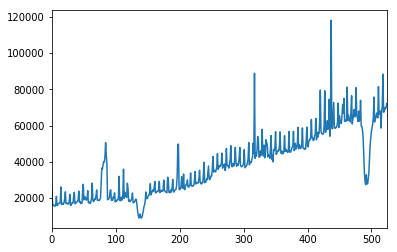

In [13]:
zone1 = train[train.ZONE_CODE == "ZONE01"].copy().reset_index()
zone1_gpby_mean = zone1.groupby("UPDATE_TIME").mean().reset_index()

zone1_gpby_mean["BANDWIDTH_TOTAL"].plot()

In [14]:
zone1_bandwidth = zone1_gpby_mean.drop(zone1_gpby_mean.index[485:502])
zone1_bandwidth = zone1_bandwidth.drop(zone1_bandwidth.index[133:146])
zone1_bandwidth = zone1_bandwidth.drop(zone1_bandwidth.index[76:88]).reset_index()

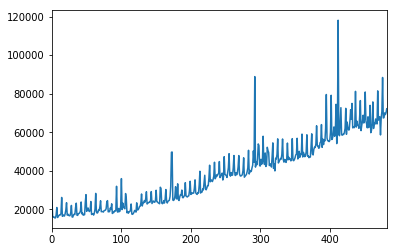

In [15]:
zone1_bandwidth["BANDWIDTH_TOTAL"].plot()

In [16]:
zone1_theta_bandwidth = linearForFeature(
    zone1_bandwidth, "count_date", "BANDWIDTH_TOTAL"
)
print(zone1_theta_bandwidth)

[[1.61308135e+04]
 [3.56787736e+01]
 [1.46720244e-01]]


In [18]:
zone1_rate_bandwidth = (
    zone1.groupby(["day_of_week", "HOUR_ID"]).mean().BANDWIDTH_TOTAL
    / zone1.mean().BANDWIDTH_TOTAL
)
for i in range(168):
    zone1.loc[
        zone1.day_of_week * 24 + zone1.HOUR_ID == i, "rate_hour_id_bandwidth"
    ] = zone1_rate_bandwidth[i // 24][i % 24]

In [19]:
zero = np.zeros((len(zone1), 1))
one = np.ones((len(zone1), 1))
count_date = zone1["count_date"][:, np.newaxis]

zone1["predict_bandwidth"] = (
    np.concatenate((one, count_date, count_date * count_date), axis=1)
    @ zone1_theta_bandwidth
)
zone1["predict_bandwidth"] = (
    zone1["predict_bandwidth"] * zone1["rate_hour_id_bandwidth"]
)

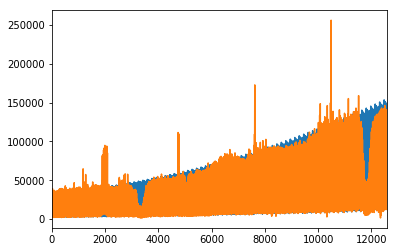

In [20]:
zone1.predict_bandwidth.plot()
zone1.BANDWIDTH_TOTAL.plot()

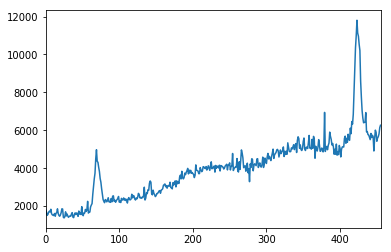

In [21]:
zone2 = train[train.ZONE_CODE == "ZONE02"].copy().reset_index()
zone2_gpby_mean = zone2.groupby("UPDATE_TIME").mean().reset_index()

zone2_gpby_mean["BANDWIDTH_TOTAL"].plot()

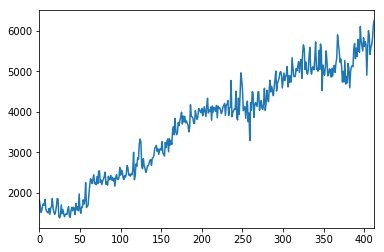

In [22]:
zone2_bandwidth = zone2_gpby_mean.drop(zone2_gpby_mean.index[415:439])
zone2_bandwidth = zone2_bandwidth.drop(zone2_bandwidth.index[379])
zone2_bandwidth = zone2_bandwidth.drop(zone2_bandwidth.index[62:80]).reset_index()
zone2_bandwidth["BANDWIDTH_TOTAL"].plot()

In [23]:
zone2_theta_bandwidth = linearForFeature(
    zone2_bandwidth, "count_date", "BANDWIDTH_TOTAL"
)
print(zone2_theta_bandwidth)

[[ 2.46400945e+02]
 [ 1.40323958e+01]
 [-6.53031705e-03]]


In [24]:
zone2_rate_bandwidth = (
    zone2.groupby(["day_of_week", "HOUR_ID"]).mean().BANDWIDTH_TOTAL
    / zone2.mean().BANDWIDTH_TOTAL
)
for i in range(168):
    zone2.loc[
        zone2.day_of_week * 24 + zone2.HOUR_ID == i, "rate_hour_id_bandwidth"
    ] = zone2_rate_bandwidth[i // 24][i % 24]

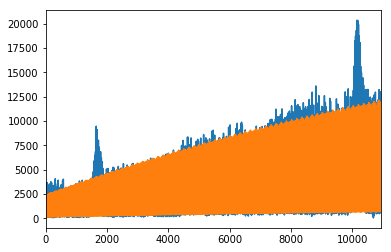

In [30]:
zero = np.zeros((len(zone2), 1))
one = np.ones((len(zone2), 1))
count_date = zone2["count_date"][:, np.newaxis]

zone2["predict_bandwidth"] = (
    np.concatenate((one, count_date, count_date * count_date), axis=1)
    @ zone2_theta_bandwidth
)
zone2["predict_bandwidth"] = (
    zone2["predict_bandwidth"] * zone2["rate_hour_id_bandwidth"]
)
zone2.BANDWIDTH_TOTAL.plot()
zone2.predict_bandwidth.plot()

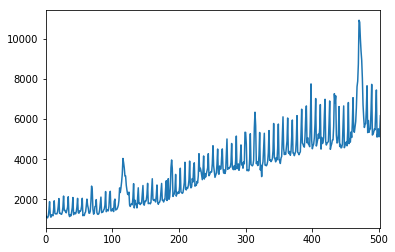

In [26]:
zone3 = train[train.ZONE_CODE == "ZONE03"].copy().reset_index()
zone3_gpby_mean = zone3.groupby("UPDATE_TIME").mean().reset_index()

zone3_gpby_mean["BANDWIDTH_TOTAL"].plot()

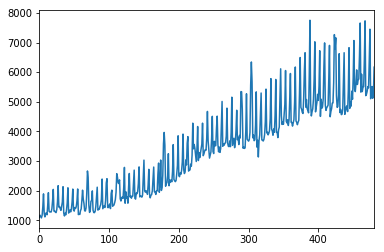

In [27]:
zone3_bandwidth = zone3_gpby_mean.drop(zone3_gpby_mean.index[465:477])
zone3_bandwidth = zone3_bandwidth.drop(zone3_bandwidth.index[112:122]).reset_index()
zone3_bandwidth["BANDWIDTH_TOTAL"].plot()

In [28]:
zone3_theta_bandwidth = linearForFeature(
    zone3_bandwidth, "count_date", "BANDWIDTH_TOTAL"
)
print(zone3_theta_bandwidth)

[[8.19292590e+02]
 [8.13488661e+00]
 [4.07882403e-03]]


In [29]:
zone3_rate_bandwidth = (
    zone3.groupby(["day_of_week", "HOUR_ID"]).mean().BANDWIDTH_TOTAL
    / zone3.mean().BANDWIDTH_TOTAL
)
for i in range(168):
    zone3.loc[
        zone3.day_of_week * 24 + zone3.HOUR_ID == i, "rate_hour_id_bandwidth"
    ] = zone3_rate_bandwidth[i // 24][i % 24]

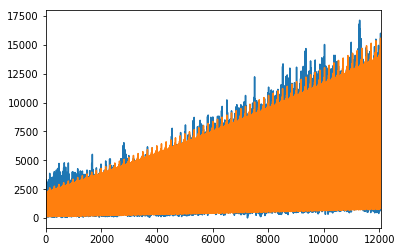

In [31]:
zero = np.zeros((len(zone3), 1))
one = np.ones((len(zone3), 1))
count_date = zone3["count_date"][:, np.newaxis]

zone3["predict_bandwidth"] = (
    np.concatenate((one, count_date, count_date * count_date), axis=1)
    @ zone3_theta_bandwidth
)
zone3["predict_bandwidth"] = (
    zone3["predict_bandwidth"] * zone3["rate_hour_id_bandwidth"]
)

zone3.BANDWIDTH_TOTAL.plot()
zone3.predict_bandwidth.plot()

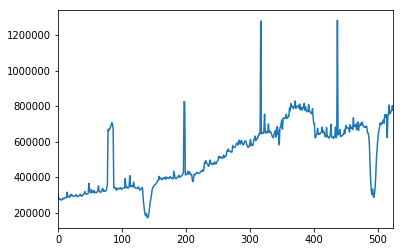

In [32]:
zone1_gpby_mean.MAX_USER.plot()

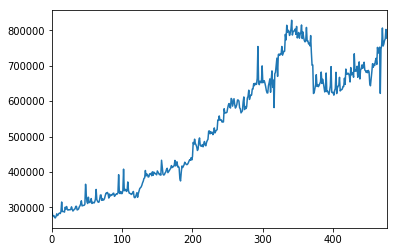

In [33]:
zone1_maxuser = zone1_gpby_mean.drop(zone1_gpby_mean.index[485:501])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[436:438])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[316:318])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[196:199])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[132:147])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[77:87]).reset_index()
zone1_maxuser["MAX_USER"].plot()

In [34]:
zone1_theta_maxuser = linearForFeature(zone1_maxuser, "count_date", "MAX_USER")
print(zone1_theta_maxuser)

[[ 2.24803236e+05]
 [ 1.36703952e+03]
 [-6.35817168e-01]]


In [35]:
zone1_rate_maxuser = (
    zone1.groupby(["day_of_week", "HOUR_ID"]).mean().MAX_USER / zone1.mean().MAX_USER
)
for i in range(168):
    zone1.loc[
        zone1.day_of_week * 24 + zone1.HOUR_ID == i, "rate_hour_id_maxuser"
    ] = zone1_rate_maxuser[i // 24][i % 24]

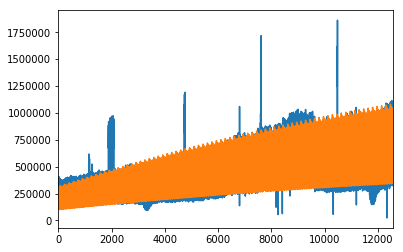

In [36]:
zero = np.zeros((len(zone1), 1))
one = np.ones((len(zone1), 1))
count_date = zone1["count_date"][:, np.newaxis]

zone1["predict_maxuser"] = (
    np.concatenate((one, count_date, count_date * count_date), axis=1)
    @ zone1_theta_maxuser
)
zone1["predict_maxuser"] = (
    zone1["predict_maxuser"] * zone1["rate_hour_id_maxuser"]
).astype(int)

zone1.MAX_USER.plot()
zone1.predict_maxuser.plot()

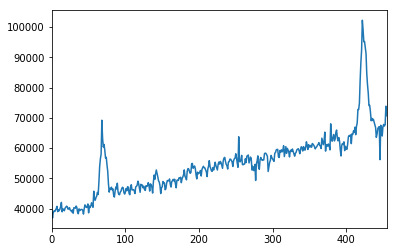

In [37]:
zone2_gpby_mean.MAX_USER.plot()

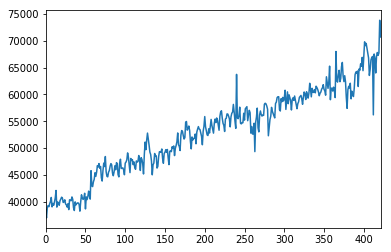

In [38]:
zone2_maxuser = zone2_gpby_mean.drop(zone2_gpby_mean.index[415:435])
zone2_maxuser = zone2_maxuser.drop(zone2_maxuser.index[64:78]).reset_index()
zone2_maxuser["MAX_USER"].plot()

In [39]:
zone2_theta_maxuser = linearForFeature(zone2_maxuser, "count_date", "MAX_USER")
print(zone2_theta_maxuser)

[[ 3.36917950e+04]
 [ 7.40968649e+01]
 [-2.26779453e-02]]


In [40]:
zone2_rate_maxuser = (
    zone2.groupby(["day_of_week", "HOUR_ID"]).mean().MAX_USER / zone2.mean().MAX_USER
)
for i in range(168):
    zone2.loc[
        zone2.day_of_week * 24 + zone2.HOUR_ID == i, "rate_hour_id_maxuser"
    ] = zone2_rate_maxuser[i // 24][i % 24]

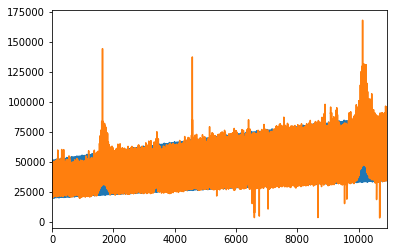

In [41]:
zero = np.zeros((len(zone2), 1))
one = np.ones((len(zone2), 1))
count_date = zone2["count_date"][:, np.newaxis]

zone2["predict_maxuser"] = (
    np.concatenate((one, count_date, count_date * count_date), axis=1)
    @ zone2_theta_maxuser
)
zone2["predict_maxuser"] = (
    zone2["predict_maxuser"] * zone2["rate_hour_id_maxuser"]
).astype(int)

zone2.predict_maxuser.plot()
zone2.MAX_USER.plot()

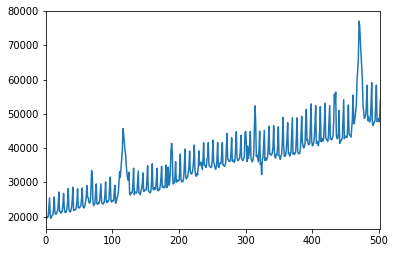

In [42]:
zone3_gpby_mean.MAX_USER.plot()

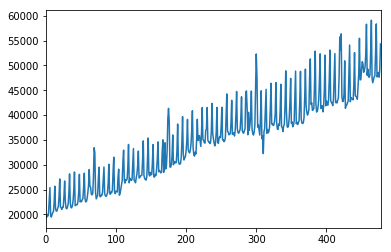

In [43]:
zone3_maxuser = zone3_gpby_mean.drop(zone3_gpby_mean.index[466:477])
zone3_maxuser = zone3_maxuser.drop(zone3_maxuser.index[110:124]).reset_index()
zone3_maxuser["MAX_USER"].plot()

In [44]:
zone3_theta_maxuser = linearForFeature(zone3_maxuser, "count_date", "MAX_USER")
print(zone3_theta_maxuser)

[[1.97383995e+04]
 [5.65237163e+01]
 [1.36363740e-03]]


In [45]:
zone3_rate_maxuser = (
    zone3.groupby(["day_of_week", "HOUR_ID"]).mean().MAX_USER / zone3.mean().MAX_USER
)
for i in range(168):
    zone3.loc[
        zone3.day_of_week * 24 + zone3.HOUR_ID == i, "rate_hour_id_maxuser"
    ] = zone3_rate_maxuser[i // 24][i % 24]

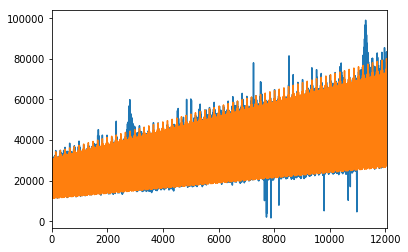

In [46]:
zero = np.zeros((len(zone3),1)) 
one = np.ones((len(zone3),1))
count_date = zone3['count_date'][:, np.newaxis]

zone3['predict_maxuser'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone3_theta_maxuser  
zone3['predict_maxuser'] = (zone3['predict_maxuser'] * zone3['rate_hour_id_maxuser']).astype(int)

zone3.MAX_USER.plot()
zone3.predict_maxuser.plot()

In [48]:
for i in range(test.shape[0]):
    # ZONE01
    if test.loc[i,'ZONE_CODE'] == 'ZONE01':
        # BANDWIDTH
        test.loc[i,'rate_hour_id_bandwidth'] = zone1_rate_bandwidth[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_bandwidth'] = zone1_theta_bandwidth[0] + zone1_theta_bandwidth[1]*test.loc[i,'count_date'] + zone1_theta_bandwidth[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
        # MAX_USER
        test.loc[i,'rate_hour_id_maxuser'] = zone1_rate_maxuser[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_maxuser'] = zone1_theta_maxuser[0] + zone1_theta_maxuser[1]*test.loc[i,'count_date'] + zone1_theta_maxuser[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
    # ZONE02
    elif test.loc[i,'ZONE_CODE'] == 'ZONE02':
        # BANDWIDTH
        test.loc[i,'rate_hour_id_bandwidth'] = zone2_rate_bandwidth[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_bandwidth'] = zone2_theta_bandwidth[0] + zone2_theta_bandwidth[1]*test.loc[i,'count_date'] + zone2_theta_bandwidth[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
        # MAX_USER
        test.loc[i,'rate_hour_id_maxuser'] = zone2_rate_maxuser[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_maxuser'] = zone2_theta_maxuser[0] + zone2_theta_maxuser[1]*test.loc[i,'count_date'] + zone2_theta_maxuser[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
    # ZONE03
    else:
        # BANDWIDTH
        test.loc[i,'rate_hour_id_bandwidth'] = zone3_rate_bandwidth[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_bandwidth'] = zone3_theta_bandwidth[0] + zone3_theta_bandwidth[1]*test.loc[i,'count_date'] + zone3_theta_bandwidth[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
        # MAX_USER
        test.loc[i,'rate_hour_id_maxuser'] = zone3_rate_maxuser[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_maxuser'] = zone3_theta_maxuser[0] + zone3_theta_maxuser[1]*test.loc[i,'count_date'] + zone3_theta_maxuser[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
    
test['predict_bandwidth'] = (test['predict_bandwidth'] * test['rate_hour_id_bandwidth']).round(2)
test['predict_maxuser'] = (test['predict_maxuser'] * test['rate_hour_id_maxuser']).astype(int)
test.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID,count_date,week,day_of_week,rate_hour_id_bandwidth,predict_bandwidth,rate_hour_id_maxuser,predict_maxuser
0,0,2019-03-10,ZONE01,0,525,75,6,0.885355,66668.96,0.840683,645015
1,1,2019-03-10,ZONE01,1,525,75,6,0.507149,38189.31,0.635614,487676
2,2,2019-03-10,ZONE01,2,525,75,6,0.328881,24765.35,0.538276,412993
3,3,2019-03-10,ZONE01,3,525,75,6,0.236844,17834.83,0.482006,369820
4,4,2019-03-10,ZONE01,4,525,75,6,0.198260,14929.36,0.473299,363139


In [49]:
test['label'] = test['predict_bandwidth'].astype(str) + " " + test['predict_maxuser'].astype(str)
test[['id','label']].to_csv('test_1.csv', index=False)
test[['id','label']].head()

,id,label
0,0,66668.96 645015
1,1,38189.31 487676
2,2,24765.35 412993
3,3,17834.83 369820
4,4,14929.36 363139
